In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.metrics import mean_absolute_error

import sys
sys.path.insert(0, '../scr')
from transformers import Impute, select_city, create_lagged_column, select_features

In [2]:
power_y=False

### Load the provided data

In [3]:
train_features = pd.read_csv('../data/dengue_features_train.csv',
                             index_col=[0,1,2])
train_labels = pd.read_csv('../data/dengue_labels_train.csv',
                           index_col=[0,1,2])
test_features = pd.read_csv('../data/dengue_features_test.csv',
                             index_col=[0,1,2])


train_features = create_lagged_column(train_features,'reanalysis_air_temp_k',lag=18)
train_features = create_lagged_column(train_features,'station_min_temp_c',lag=4)
train_features = create_lagged_column(train_features,'station_precip_mm',lag=4)
train_features = create_lagged_column(train_features,'station_precip_mm',lag=6)


test_features = create_lagged_column(test_features,'reanalysis_air_temp_k',lag=18)
test_features = create_lagged_column(test_features,'station_min_temp_c',lag=4)
test_features = create_lagged_column(test_features,'station_precip_mm',lag=4)
test_features = create_lagged_column(test_features,'station_precip_mm',lag=6)

### Splitting the provided training data by city and into train and validation data for each city

In [4]:
# initialize dictionaries to hold the train and validation data for each city
full_train_X = {}
test_X = {}
train_X = {}
validate_X = {}
full_train_y = {}
train_y = {}
validate_y = {}
cities = ['sj', 'iq']
city_names = {'sj':'San Juan, Puerto Rico', 'iq':'Iquitos, Peru' }

# make the train validation split
for city in cities:
    full_train_X [city] = select_city(train_features, city = city)
    full_train_y [city] = select_city(train_labels, city = city)
    test_X [city] = select_city(test_features, city = city)
    
    assert len(full_train_X [city]) == len(full_train_y [city])
    
    split_idx = int(len(full_train_X[city])*0.8)
    
    train_X [city] = full_train_X [city].head(split_idx)
    train_y [city] = full_train_y [city].head(split_idx)
    
    validate_X [city] = full_train_X [city].tail(len(full_train_X[city]) - split_idx)
    validate_y [city] = full_train_y [city].tail(len(full_train_y[city]) - split_idx)
    

Check that the split worked

In [5]:
for city in cities:
    print('------------- '+city_names[city]+' -----------------')
    print("training")
    print('X', train_X[city].shape, 'y', train_y[city].shape)
    print('validation')
    print('X', validate_X[city].shape, 'y', validate_y[city].shape)
    print('all')
    print('X', full_train_X[city].shape, 'y', full_train_y[city].shape,'\n')

------------- San Juan, Puerto Rico -----------------
training
X (748, 25) y (748, 1)
validation
X (188, 25) y (188, 1)
all
X (936, 25) y (936, 1) 

------------- Iquitos, Peru -----------------
training
X (416, 25) y (416, 1)
validation
X (104, 25) y (104, 1)
all
X (520, 25) y (520, 1) 



### Build a pipeline

In [6]:
# build the general setup of the pipeline

# I added the SimpleImputer, because the ffill method fails when there is a nan value in the first row,
# the first row is filled with the median in that case

# define parameters for the different transformers

myfeatures = {}

############ for including 1 lagged features with high correlation #################
#myfeatures['sj'] =  ['reanalysis_specific_humidity_g_per_kg',
#                   'station_avg_temp_c',
#                   'reanalysis_dew_point_temp_k',
#                    'reanalysis_max_air_temp_k',
#                    'reanalysis_air_temp_k_lagged_18.00']

#myfeatures['iq'] = ['reanalysis_specific_humidity_g_per_kg',
#                    'station_avg_temp_c',
#                    'reanalysis_dew_point_temp_k',
#                    'reanalysis_max_air_temp_k',
#                   'station_min_temp_c_lagged_4.00']

############ for including 2 lagged features with high correlation #################
myfeatures['sj'] =  ['reanalysis_specific_humidity_g_per_kg',
                   'station_avg_temp_c',
                   'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k',
                    'reanalysis_air_temp_k_lagged_18.00',
                    'station_precip_mm_lagged_4.00']

myfeatures['iq'] = ['reanalysis_specific_humidity_g_per_kg',
                    'station_avg_temp_c',
                    'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k',
                   'station_min_temp_c_lagged_4.00',
                   'station_precip_mm_lagged_6.00']

########### for linear regression with 4 top correlated (non-lag) features#####

myfeatures['iq'] = ['reanalysis_max_air_temp_k', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'reanalysis_specific_humidity_g_per_kg']#

myfeatures['sj'] = ['reanalysis_specific_humidity_g_per_kg',
                    'station_avg_temp_c',
                    'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k']
########################################################################

FeatureSelector={}

for city in cities:
    FeatureSelector[city] = FunctionTransformer(func = select_features, check_inverse = False,
                                              kw_args={'features' : myfeatures[city]})
pipe ={}
for city in cities:
    pipe[city] = Pipeline(steps=[('feature_selection', FeatureSelector[city]), ('ffill_nans', Impute),
                       ('median_nans', SimpleImputer(strategy='median')),('scaler', RobustScaler()),('make_more_gaussian',PowerTransformer())])
#('poly',PolynomialFeatures(degree=2))

# Here, we set the parameters for all the transformers that we use in the pipeline

for city in cities:
    # Here, we add whatever model we want to use as a last step in the pipeline
    #pipe[city].steps.append(('lin_reg', Ridge(alpha=.3)))
     pipe[city].steps.append(('xgb',xgb.XGBRegressor(max_depth=3)))


#this_pipe.steps.append(('lin_reg', ElasticNet(alpha=.1)))

In [7]:
train_X[city].columns

Index(['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm',
       'reanalysis_air_temp_k_lagged_18.00', 'station_min_temp_c_lagged_4.00',
       'station_precip_mm_lagged_4.00', 'station_precip_mm_lagged_6.00'],
      dtype='object')

### Training one model per city

In [8]:
# we train one model per city and save them in this dictionary
model = {}
transformer_train = {}
for city in cities:
    if power_y:
        transformer_train[city]=PowerTransformer().fit(train_y[city])
        model[city] = pipe[city].fit(train_X[city], transformer_train[city].transform(train_y[city]))
    else:
        model[city] = pipe[city].fit(train_X[city], train_y[city])


[15:19:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [9]:
if power_y:
    plt.hist(transformer_train['sj'].transform(train_y['sj']))

### Predicting on training and validation data set for each city

In [10]:
pred_train = {}
pred_valid = {}

for city in cities:
    if power_y:
        pred_train[city] = transformer_train[city].inverse_transform(model[city].predict(train_X[city]))
        pred_valid[city] = transformer_train[city].inverse_transform(model[city].predict(validate_X[city]))
    else:
        pred_train[city] = model[city].predict(train_X[city])
        pred_valid[city] = model[city].predict(validate_X[city])
        

### Quality of the model

In [11]:
print('MEAN ABSOLUTE ERROR\n')
print('best model\n')

for city in cities:
    print('------ '+city_names[city]+' ---------')
    print(f'Training:   {mean_absolute_error(train_y[city], pred_train[city]):1.4f}')
    print(f'Validation: {mean_absolute_error(validate_y[city], pred_valid[city]):1.4f}\n')

MEAN ABSOLUTE ERROR

best model

------ San Juan, Puerto Rico ---------
Training:   20.3410
Validation: 33.3560

------ Iquitos, Peru ---------
Training:   3.9239
Validation: 8.1998



In [12]:
# maybe here, we could save the pipeline and the errors and hyper parameters (and later also a plot)?

### Plot of predictions

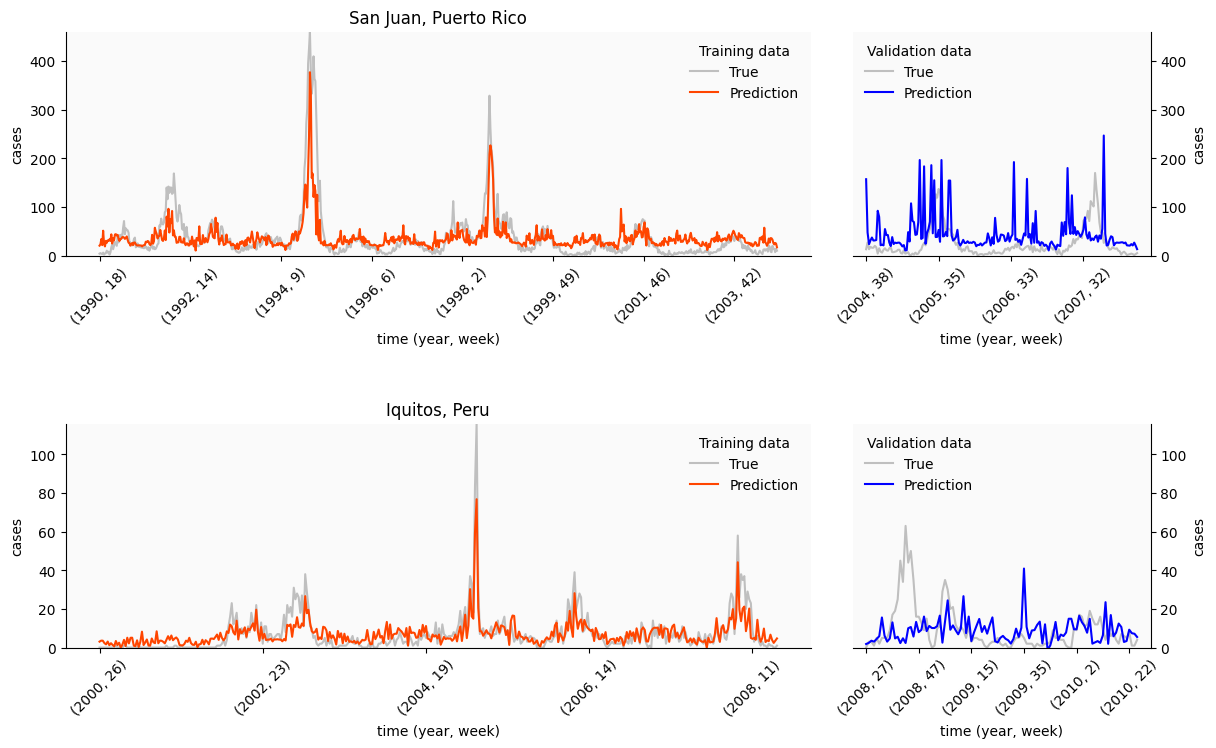

In [13]:
# attention, attention, this really depends on pandas and everyone not mixing up the rows

training_results = {}
validation_results = {}

# setting up figure with subplots
fig, axes = plt.subplots(2, 2, gridspec_kw = {'width_ratios':[2.5, 1]})
fig.set_size_inches(14,8)  
axes = axes.flatten()
for i in range(4):
    axes[i].spines['top'].set_visible(False)
    if i%2:
        axes[i].yaxis.tick_right()
        axes[i].spines['left'].set_visible(False)
        axes[i].yaxis.set_label_position("right")
    else:
        axes[i].spines['right'].set_visible(False)        
        
plt.subplots_adjust(hspace = 0.75, wspace = 0.08)

# combine the prediction and true values in one dataframe
for city in cities:
    training_results[city] = train_y[city].copy()
    training_results[city]['pred'] = pred_train[city]
    validation_results[city] = validate_y[city].copy()
    validation_results[city]['pred'] = pred_valid[city]

# plot the predictions and true values for each city and each data set (training/validation)
for i, city in enumerate(cities):
    training_results[city].plot(y = ['total_cases', 'pred'], ax = axes[2*i], 
                                label = ['True', 'Prediction'], color = ['.75','orangered'])
    validation_results[city].plot(y = ['total_cases','pred'], ax = axes[2*i+1], 
                                  label = ['True','Prediction'], color = ['.75','b'])
    axes[2*i].set_title(city_names[city])
    axes[2*i].set_ylim(0,full_train_y[city].total_cases.max())
    axes[2*i+1].set_ylim(0,full_train_y[city].total_cases.max())
    
# format axes
legend_title=['Training data','Validation data']*2
for i in range(4):
    axes[i].set_ylabel('cases')
    axes[i].set_xlabel('time (year, week)')
    axes[i].legend(frameon=False, title = legend_title[i], loc = i%2+1)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_facecolor('.98')

### Fit the model to ALL the data

In [14]:
final_model = {}
final_transformer = {}
for city in cities:
    if power_y:
        final_transformer[city]=PowerTransformer().fit(full_train_y[city])
        final_model[city] = pipe[city].fit(full_train_X[city], final_transformer[city].transform(full_train_y[city]))        
    else:    
        final_model[city] = pipe[city].fit(full_train_X[city], full_train_y[city])

[15:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Predict the test data set

In [15]:
pred_test = {}
for city in cities:
    if power_y:
        pred_test[city] = final_transformer[city].inverse_transform(final_model[city].predict(test_X[city]))        
    else:
        pred_test[city] = final_model[city].predict(test_X[city])

In [16]:
if power_y:
    city='sj'
    fig,ax=plt.subplots(2)
    full_train_y[city].hist(bins=50,ax=ax[0])
    ax[1].hist(final_transformer[city].transform(full_train_y[city]),bins=50)
    plt.gca().grid(False)
    ax[0].set_xlabel('total cases')
    ax[1].set_xlabel('transformed number of total cases')
    ax[0].set_title(city_names[city])
    #plt.gca().set_xlim(-5,5)
    ax[0].grid(False)
    for i in range(2):
        ax[i].set_ylabel('# occurences')

### Get the prediction into the right format for submission

In [17]:
results = []
for city in cities:
    df_hlp = test_X[city].copy()
    df_hlp['total_cases'] = pred_test[city]
    df_hlp = pd.concat([df_hlp], keys=[city], names=['city'])
    results.append(pd.DataFrame(df_hlp.total_cases.astype(int)))
final = pd.concat(results)
final.to_csv('../predictions/prediction.csv')

Text(0, 0.5, 'predicted cases')

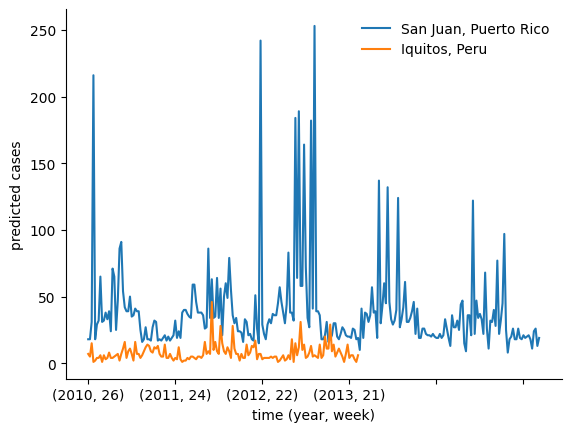

In [18]:
fig,ax=plt.subplots(1)

for city in cities:
    final.loc[city].plot(y='total_cases',ax=ax,label=city_names[city])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().legend(frameon=False)
plt.gca().set_xlabel('time (year, week)')
plt.gca().set_ylabel('predicted cases')

In [19]:
final

total_cases
city year weekofyear             
sj   2008 18                   18
          19                   18
          20                   31
          21                  216
          22                   18
...                           ...
iq   2013 22                    6
          23                    6
          24                    3
          25                    1
          26                    6

[416 rows x 1 columns]